# XGBoost

Add description. 

Import libraries. 

In [1]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 
from collections import Counter

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train_res = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/X_train_res.csv')
y_train_res = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/y_train_res.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/X_test.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/y_test.csv')

X_train_res = X_train_res.drop(columns='Unnamed: 0', axis=1)
y_train_res = y_train_res.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

# Convert the DataFrame to a NumPy array
# y_test = y_test.to_numpy()

# Display the first few rows of each dataframe to verify the loading
print("X_train_res:")
display(X_train_res.head())

print("\ny_train_res:")
display(y_train_res.head())

print("\nX_test:")
display(X_test.head())

print("\ny_test:")
# print(y_test)
display(y_test.head())

# Convert the DataFrame to a 1-dimensional NumPy array
y_train_res = y_train_res.values.ravel()
y_test = y_test.values.ravel()

X_train_res:


,VVR_1,VVR_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,12.0,13.0,-0.070220,-0.403569,-0.161650,0.428359,-0.673859,-0.387663,0.994371,0.345623,...,-0.537730,0.225549,-1.036133,-0.951754,-1.025247,-1.526773,-1.479742,-1.237893,-2.161830,-2.049390
1,10.0,10.0,2.226447,1.288304,1.124217,0.514376,0.729448,1.091318,3.433959,2.208680,...,0.774622,0.458331,0.368352,0.632011,1.209277,-0.225126,-0.001447,0.619766,-0.202961,-0.127515
2,8.0,8.0,-0.328541,-0.286339,-0.049149,0.514376,-0.191466,-0.152619,-0.351110,-0.286124,...,0.539267,0.408449,0.316323,0.450683,-0.834081,-0.909004,-0.642000,0.297037,-1.125698,-0.981679
3,10.0,8.0,-0.179816,1.024130,0.956659,0.514376,0.292720,0.824388,-0.176376,0.226388,...,0.891064,0.458331,0.480862,0.766552,-0.208294,0.810246,0.749643,0.257680,0.422548,0.743912
4,8.0,8.0,-0.687261,-0.791730,-0.584920,0.514376,-0.763173,-0.767495,-0.530851,-0.455929,...,-0.558621,0.366881,-0.858611,-0.877156,-0.419249,-0.490562,-0.230352,-0.340549,-0.573360,-0.444615



y_train_res:


,VVR_group
0,1
1,1
2,0
3,0
4,0



X_test:


,VVR_1,VVR_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,10.0,11.0,-1.088267,-0.486929,-0.245322,-0.094909,-0.387079,-0.373556,-0.296967,1.267608,...,-1.106604,-1.661648,-0.939358,-1.258986,-0.862599,0.657150,0.649175,0.619766,0.540339,0.684272
1,19.0,21.0,0.160204,0.681681,0.725849,0.514376,0.751085,0.775827,0.031562,0.457413,...,1.791290,0.458331,1.507769,1.887518,-0.111414,0.662918,0.653014,0.478080,0.552052,0.691181
2,8.0,8.0,-0.510947,-0.678086,-0.451146,-0.130749,-0.740730,-0.650167,-0.512662,-0.414737,...,0.412202,0.458331,-0.395816,0.012935,0.703933,1.133047,0.952462,0.619766,0.765365,1.028129
3,21.0,21.0,1.139765,0.115481,0.300321,0.406855,0.152945,0.239720,0.621775,-0.239594,...,-0.009577,0.017708,-0.227168,-0.190216,1.476715,0.191834,0.323467,0.493823,0.412243,0.350324
4,11.0,8.0,1.257027,1.622690,1.325337,0.514376,1.084273,1.365502,1.155021,1.601645,...,0.075374,0.217235,-0.256234,-0.149869,-0.194813,-0.655535,-0.383937,-0.104406,-0.685164,-0.617897



y_test:


,VVR_group
0,0
1,1
2,0
3,1
4,0


In [12]:
import logging

def evaluate_model(model, X, y):
    """
    Evaluate the model's performance
    """
    model.fit(X, y)
    y_probs = model.predict_proba(X)[:, 1]
    precision = precision_score(y, model.predict(X))
    recall = recall_score(y, model.predict(X))
    f1 = f1_score(y, model.predict(X))
    precision_curve, recall_curve, _ = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall_curve, precision_curve)
    cm = confusion_matrix(y, model.predict(X))
    
    logging.info(f"Precision: {precision}")
    logging.info(f"Recall: {recall}")
    logging.info(f"F1-score: {f1}")
    logging.info(f"AUC-PR score: {auc_pr}")
    logging.info(f"Confusion Matrix:")
    logging.info(cm)

# Model with inner and outer split 

In [24]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
rfe = RFE(estimator=DecisionTreeClassifier())
model = XGBClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__learning_rate': [0.1, 0.01],  # Learning rate
    'm__n_estimators': [50, 100, 200],  # Number of trees
    'm__max_depth': [3, 5, 8],  # Maximum depth of a tree
    'm__min_child_weight': [1, 5],  # Minimum sum of instance weight needed in a child
    's__n_features_to_select': [5, 10, 15, 20]  # Number of features to select with RFE
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_res.shape)
print(y_train_res.shape)

# Fit model to training data to get best parameters
model.fit(X_train_res, y_train_res)

# Print best parameters
print(model.best_params_)

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")

# evaluate_model(model, X_test, y_test)


The mean score using nested cross-validation is: 0.839 ± 0.024
(112, 104)
(112,)
{'m__learning_rate': 0.1, 'm__max_depth': 5, 'm__min_child_weight': 1, 'm__n_estimators': 100, 's__n_features_to_select': 10}
(32,)
(32,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.57      0.57      0.57         7

    accuracy                           0.81        32
   macro avg       0.73      0.73      0.73        32
weighted avg       0.81      0.81      0.81        32

[[22  3]
 [ 3  4]]


# Confusion Matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_5002/527580699.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


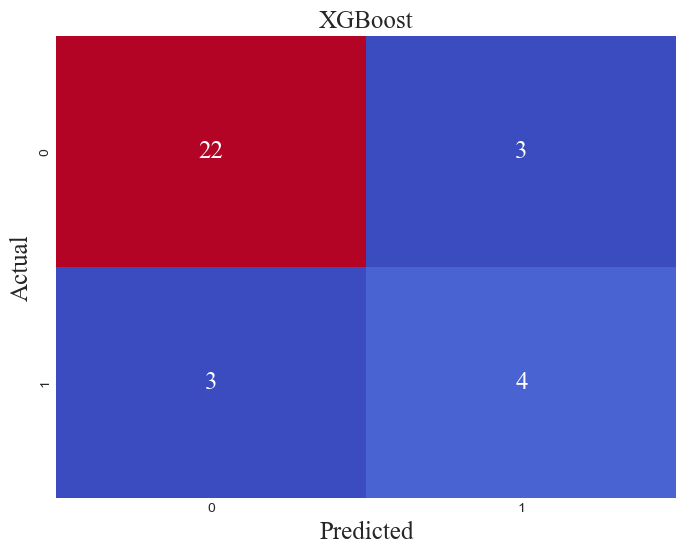

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('XGBoost', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()
